In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import textwrap
import numpy as np
# model_id = "meta-llama/Llama-3.3-70B-Instruct"
model_id = "allenai/OLMo-2-1124-7B-Instruct"
bnb_conf = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # quantization_config=bnb_conf,
)
# model.to("cuda")

/home/user/miniconda3/envs/graphing/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:14<00:00,  4.84s/it]


Token: As, Loss: 6.435646057128906
Token:  we, Loss: 4.223746299743652
Token:  continue, Loss: 0.43863123655319214
Token:  to, Loss: 2.344987392425537
Token:  explore, Loss: 3.4129672050476074
Token:  new, Loss: 10.053311347961426
Token:  post, Loss: 1.9739935398101807
Token: -, Loss: 7.6790876388549805
Token: training, Loss: 3.368152618408203
Token:  techniques, Loss: 0.9956168532371521
Token: ,, Loss: 6.891091346740723
Token:  today, Loss: 0.5458349585533142
Token:  we, Loss: 2.767644166946411
Token: 're, Loss: 8.523346900939941
Token:  releasing, Loss: 14.905782699584961
Token: L, Loss: 4.969717025756836
Token: lama, Loss: 2.585758924484253
Token:  , Loss: 1.5226322412490845
Token: 3, Loss: 2.9343149662017822
Token: ., Loss: 3.4240970611572266
Token: 3, Loss: 3.819705009460449
Token: ,, Loss: 3.107205390930176
Token:  a, Loss: 4.788715362548828
Token:  new, Loss: 0.29661956429481506
Token:  open, Loss: 6.3198981285095215
Token:  source, Loss: 5.459931373596191
Token:  model, Loss: 5

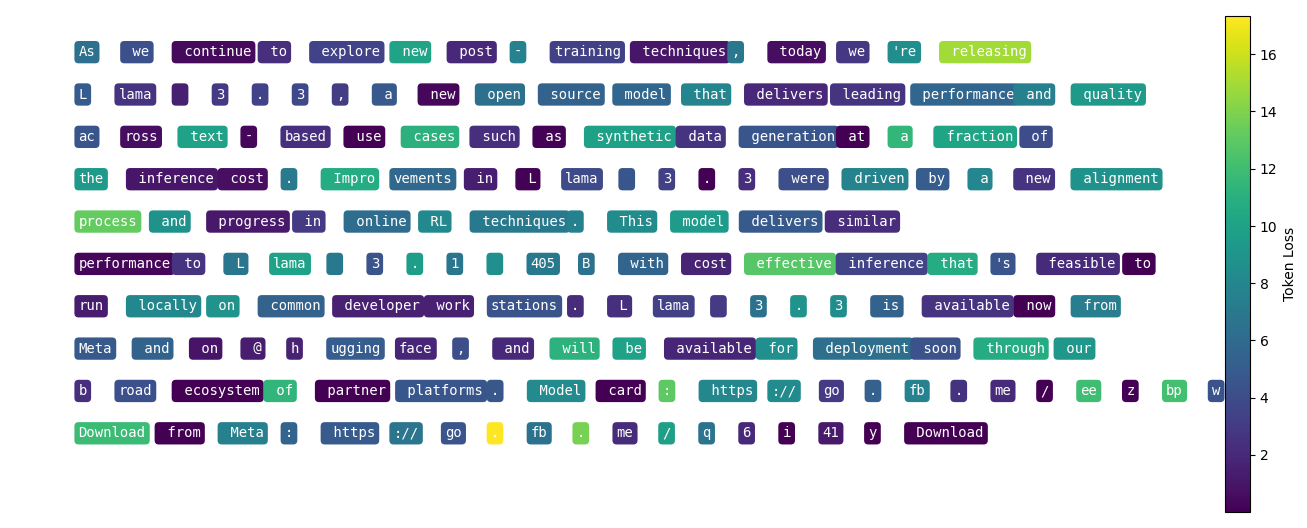

In [3]:
# Define a function to calculate the loss for each token
def calculate_token_loss(inputs):
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    logits = outputs.logits
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = inputs["input_ids"][..., 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    token_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    token_loss = token_loss.view(shift_labels.size())
    return token_loss

# Define a function to visualize the tokens with colors based on their loss
def visualize_token_loss(prompt):
    # Wrap the text into lines of a specified width
    wrapped_lines = textwrap.wrap(prompt, width=80)
    
    token_losses = []
    tokens = []
    
    for line in wrapped_lines:
        inputs = tokenizer(line, return_tensors="pt").to(model.device)
        token_loss = calculate_token_loss(inputs)
        token_losses.extend(token_loss[0].cpu().numpy())
        tokens.extend(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True))
    
    # Replace 'Ġ' with a space in tokens
    tokens = [token.replace('Ġ', ' ') for token in tokens]
    
    # Print each token with its loss
    for token, loss in zip(tokens, token_losses):
        print(f"Token: {token}, Loss: {loss}")
    
    # Normalize the loss values for coloring
    norm = plt.Normalize(min(token_losses), max(token_losses))
    colors = cm.viridis(norm(token_losses))
    
    # Ensure the lengths match
    colors = colors[:len(tokens)]
    
    # Adjust figure size based on the number of lines
    num_lines = len(wrapped_lines)
    fig_width = 16
    fig_height = num_lines * 0.6  # Adjusted height to reduce spacing between rows
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='white')
    
    # Plot the tokens with background colors
    y = num_lines - 1
    token_idx = 0
    for line in wrapped_lines:
        inputs = tokenizer(line, return_tensors="pt").to(model.device)
        line_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True)
        line_tokens = [token.replace('Ġ', ' ') for token in line_tokens]
        x = 0
        for token in line_tokens:
            if token_idx < len(colors):
                text = ax.text(x, y, token, fontsize=10, ha='left', va='center', fontfamily='monospace',
                               bbox=dict(facecolor=colors[token_idx], edgecolor='none', boxstyle='round,pad=0.3'), color='white')
                fig.canvas.draw()  # Draw the canvas to get the correct text width
                text_width = text.get_window_extent(renderer=fig.canvas.get_renderer()).width / fig.dpi
                x += text_width + 0.5  # Move x position to the right by the width of the text plus more padding
                token_idx += 1
        y -= 1  # Move to the next line
    
    ax.set_xlim(-1, fig_width)
    ax.set_ylim(-1, num_lines)  # Adjusted ylim to reduce spacing between rows
    ax.axis('off')

    # Add a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Token Loss')
    
    plt.show()

# Display the visualization in the Jupyter Notebook
prompt = """As we continue to explore new post-training techniques, today we're releasing 
Llama 3.3, a new open source model that delivers leading performance 
and quality across text-based use cases such as synthetic data generation at a 
fraction of the inference cost. Improvements in Llama 3.3 were driven by 
a new alignment process and progress in online RL techniques. This model delivers 
similar performance to Llama 3.1 405B with cost effective inference that's 
feasible to run locally on common developer workstations. Llama 3.3 is 
available now from Meta and on @huggingface, and will be available for 
deployment soon through our broad ecosystem of partner platforms.
Model card: https://go.fb.me/eezbpw
Download from Meta: https://go.fb.me/q6i41y
Download on HF: https://huggingface.co/
"""
prompt_full = """As we continue to explore new post-training techniques, today we're releasing Llama 3.3, a new open source model that delivers leading performance and quality across text-based use cases such as synthetic data generation at a fraction of the inference cost. Improvements in Llama 3.3 were driven by a new alignment process and progress in online RL techniques. This model delivers similar performance to Llama 3.1 405B with cost effective inference that's feasible to run locally on common developer workstations. Llama 3.3 is available now from Meta and on @huggingface, and will be available for deployment soon through our broad ecosystem of partner platforms. Model card: https://go.fb.me/eezbpw Download from Meta: https://go.fb.me/q6i41y Download on HF: https://huggingface.co/
"""
visualize_token_loss(prompt_full)

In [4]:
prompt2 = """As we continue to explore new post-training techniques, today we're releasing Llama 3.3, a new open source model that delivers leading performance and quality across text-based use cases such as synthetic data generation at a fraction of the inference cost. Improvements in Llama 3.3 were driven by a new alignment process and progress in online """

inputs = tokenizer(prompt2, return_tensors="pt").to(model.device)

outputs = model.generate(
    **inputs,
    do_sample=False,
    temperature=0.001,
    max_new_tokens=10,
    return_dict_in_generate=True,
    output_scores=True,
    )
# print(outputs)
# scores = outputs.scores

# print(scores)

# tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)
input_length = inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    score = score.cpu()
    tok = tok.cpu()
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")


/home/user/miniconda3/envs/graphing/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


|    18 | 3        | -1.166 | 31.16%
|    35 | D        | -0.372 | 68.95%
| 21568 |  rendering | -1.540 | 21.44%
| 12823 |  techniques | -1.813 | 16.31%
|    13 | .        | -0.657 | 51.82%
|   198 | 
        | -1.161 | 31.31%
|   198 | 
        | -0.010 | 99.04%
|  1622 | Key      | -1.220 | 29.51%
| 20289 |  Features | -0.884 | 41.31%
|    25 | :        | -0.329 | 71.99%


In [5]:
import pandas as pd

# Extract input_ids and attention_mask from inputs
input_ids = inputs['input_ids'].cpu().numpy()
attention_mask = inputs['attention_mask'].cpu().numpy()

# Create a DataFrame from the input_ids and attention_mask
df_inputs = pd.DataFrame({
    'input_ids': input_ids[0],
    'attention_mask': attention_mask[0]
})

print(df_inputs)

    input_ids  attention_mask
0        2170               1
1         584               1
2        3136               1
3         311               1
4       13488               1
..        ...             ...
68        323               1
69       5208               1
70        304               1
71       2930               1
72        220               1

[73 rows x 2 columns]
